In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to dataset
data_dir = r"C:\Users\iyera\Desktop\NEW_STRA\Strawberry_train_unet"

# Image size
img_size = 64

# Define transformations (augmentation + normalization)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load dataset with the same preprocessing for train and val
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into train and validation sets (e.g., 80%-20%)
train_size = int(0.80 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Using device: cuda
Train samples: 1252, Validation samples: 313


### Mobile ViT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.optim import AdamW

# ----------------------------------------------------
# Convolutional Block
# ----------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# ----------------------------------------------------
# Transformer Encoder Block
# ----------------------------------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads=4, mlp_dim=256, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, seq_len, dim)
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm2 = self.norm2(x)
        x = x + self.dropout(self.mlp(x_norm2))
        return x

# ----------------------------------------------------
# MobileViT Block
# ----------------------------------------------------
class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel):
        super().__init__()
        self.conv1 = ConvBlock(channel, channel)
        self.conv2 = ConvBlock(channel, dim)
        self.transformer = nn.Sequential(*[TransformerEncoder(dim) for _ in range(depth)])
        self.conv3 = ConvBlock(dim, channel)

    def forward(self, x):
        y = x
        x = self.conv1(x)
        x = self.conv2(x)

        b, d, h, w = x.shape

        # Flatten spatial dimensions for MultiheadAttention
        x = rearrange(x, 'b d h w -> b (h w) d')  # (B, seq_len, dim)
        x = self.transformer(x)
        x = rearrange(x, 'b (h w) d -> b d h w', h=h, w=w)  # back to (B, D, H, W)

        x = self.conv3(x)
        x = x + y
        return x

# ----------------------------------------------------
# Complete MobileViT Model for Binary Classification
# ----------------------------------------------------
class MobileViT(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = ConvBlock(3, 16, 3, 2, 1)
        self.layer1 = ConvBlock(16, 32, 3, 2, 1)
        self.layer2 = ConvBlock(32, 64, 3, 2, 1)

        self.mvit_block1 = MobileViTBlock(dim=64, depth=2, channel=64)
        self.layer3 = ConvBlock(64, 96, 3, 2, 1)
        self.mvit_block2 = MobileViTBlock(dim=96, depth=4, channel=96)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.mvit_block1(x)
        x = self.layer3(x)
        x = self.mvit_block2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ----------------------------------------------------
# Initialize Model, Optimizer, Criterion
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1 = MobileViT(num_classes=2).to(device)

optimizer = AdamW(model_1.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("✅ MobileViT Model ready with AdamW + L2 regularization")


✅ MobileViT Model ready with AdamW + L2 regularization


Epoch [1/50] | Train Loss: 0.3660, Train Acc: 86.09% | Val Loss: 0.3232, Val Acc: 91.47%
Epoch [2/50] | Train Loss: 0.1691, Train Acc: 94.92% | Val Loss: 0.1573, Val Acc: 95.22%
Epoch [3/50] | Train Loss: 0.1915, Train Acc: 93.98% | Val Loss: 0.1294, Val Acc: 96.56%
Epoch [4/50] | Train Loss: 0.1595, Train Acc: 95.62% | Val Loss: 0.1410, Val Acc: 96.16%
Epoch [5/50] | Train Loss: 0.1090, Train Acc: 96.64% | Val Loss: 0.1252, Val Acc: 95.94%
Epoch [6/50] | Train Loss: 0.1346, Train Acc: 94.84% | Val Loss: 0.1335, Val Acc: 95.31%
Epoch [7/50] | Train Loss: 0.1615, Train Acc: 95.23% | Val Loss: 0.0947, Val Acc: 97.81%
Epoch [8/50] | Train Loss: 0.1079, Train Acc: 96.09% | Val Loss: 0.0628, Val Acc: 97.19%
Epoch [9/50] | Train Loss: 0.1473, Train Acc: 95.00% | Val Loss: 0.0924, Val Acc: 96.56%
Epoch [10/50] | Train Loss: 0.1587, Train Acc: 94.53% | Val Loss: 0.0926, Val Acc: 97.50%
Epoch [11/50] | Train Loss: 0.1060, Train Acc: 96.17% | Val Loss: 0.0748, Val Acc: 98.12%
Epoch [12/50] | Tra

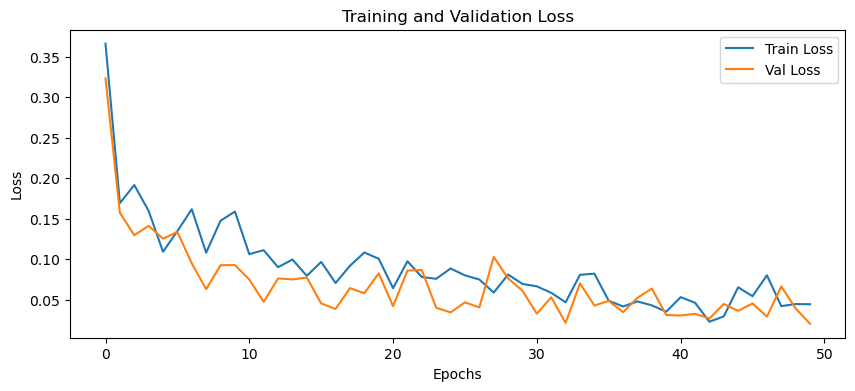

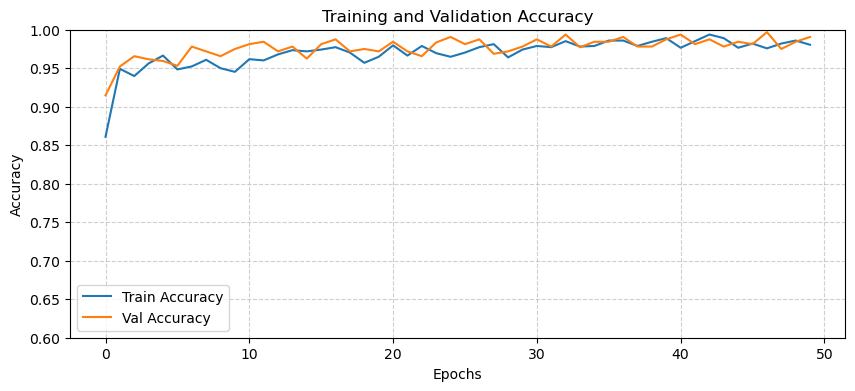

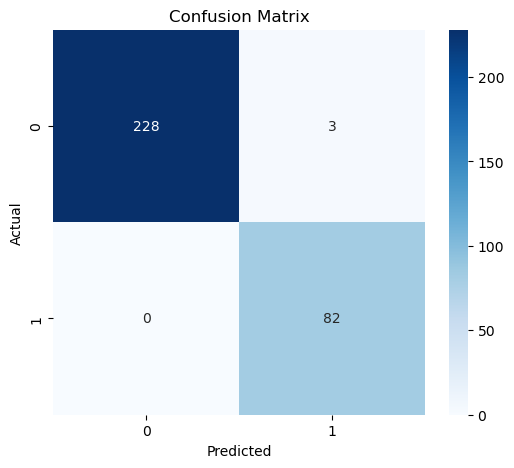

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# -----------------------------
# Store metrics
# -----------------------------
train_losses, train_accs = [], []
val_losses, val_accs = [], []

num_epochs = 50

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

# -----------------------------
# Training loop with metrics tracking
# -----------------------------
for epoch in range(1, num_epochs + 1):
    model_1.train()
    train_loss, train_acc, num_batches = 0.0, 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, labels).item()
        num_batches += 1

    train_loss /= num_batches
    train_acc /= num_batches
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model_1.eval()
    val_loss, val_acc, val_batches = 0.0, 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_1(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels).item()
            val_batches += 1

            # For confusion matrix
            preds = torch.argmax(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    val_loss /= val_batches
    val_acc /= val_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# -----------------------------
# Plot Loss
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.ylim(0.6, 1.0)  # 🔹 Adjust this range to your liking (e.g., (0, 1) for full scale)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# -----------------------------
# Confusion Matrix
# -----------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Convert to numpy
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Accuracy:  99.04%
Precision: 99.08%
Recall:    99.04%
F1 Score:  99.05%


In [ ]:
############ TEST on REAL DATA IMAGES ############

Accuracy:       91.67%
Precision:      91.72%
Recall:         91.67%
F1 Score:       91.67%
Cohen Kappa:    0.8333
MCC:            0.8338

Average Inference Time per Image: 3.76 ms
Fastest Inference Time: 2.50 ms
Slowest Inference Time: 6.99 ms

Model Size: 3.44 MB


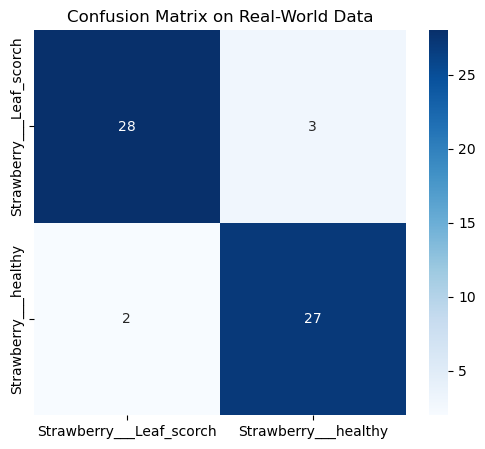

In [ ]:
import os
import time
from torchvision import transforms
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Path to real-world data
# -----------------------------
test_dir = r"C:\Users\iyera\Desktop\NEW_STRA\Real_Time_data_segmented_v2"

# Transformation
img_size = 64
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set model to eval
model_1.eval()
model_1.to(device)

# Class names
class_names = full_dataset.classes  # ['healthy', 'scrotch']

# -----------------------------
# Collect predictions and labels
# -----------------------------
y_true, y_pred = [], []
inference_times = []

for label_idx, class_folder in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # -----------------------------
        # Measure inference time
        # -----------------------------
        start = time.time()
        with torch.no_grad():
            outputs = model_1(image)
        end = time.time()

        inference_times.append(end - start)

        pred_idx = torch.argmax(outputs, 1).item()

        y_true.append(label_idx)
        y_pred.append(pred_idx)

# -----------------------------
# Compute metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:       {accuracy*100:.2f}%")
print(f"Precision:      {precision*100:.2f}%")
print(f"Recall:         {recall*100:.2f}%")
print(f"F1 Score:       {f1*100:.2f}%")
print(f"Cohen Kappa:    {kappa:.4f}")
print(f"MCC:            {mcc:.4f}")

# -----------------------------
# Inference time results
# -----------------------------
avg_inference = sum(inference_times) / len(inference_times)
print(f"\nAverage Inference Time per Image: {avg_inference*1000:.2f} ms")
print(f"Fastest Inference Time: {min(inference_times)*1000:.2f} ms")
print(f"Slowest Inference Time: {max(inference_times)*1000:.2f} ms")

# -----------------------------
# Model Size
# -----------------------------
model_path = "temp_model.pth"
torch.save(model_1.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")
os.remove(model_path)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Real-World Data")
plt.show()


### Micro ViT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.optim import AdamW

# ----------------------------------------------------
# Convolutional Block
# ----------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# ----------------------------------------------------
# Transformer Encoder Block (for Micro-ViT)
# ----------------------------------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads=2, mlp_dim=128, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, seq_len, dim)
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        x_norm2 = self.norm2(x)
        x = x + self.dropout(self.mlp(x_norm2))
        return x

# ----------------------------------------------------
# Micro-ViT Block
# ----------------------------------------------------
class MicroViTBlock(nn.Module):
    def __init__(self, dim, depth, channel):
        super().__init__()
        self.conv1 = ConvBlock(channel, channel)
        self.conv2 = ConvBlock(channel, dim)
        self.transformer = nn.Sequential(*[TransformerEncoder(dim) for _ in range(depth)])
        self.conv3 = ConvBlock(dim, channel)

    def forward(self, x):
        y = x
        x = self.conv1(x)
        x = self.conv2(x)

        b, d, h, w = x.shape
        # Flatten spatial dimensions for transformer
        x = rearrange(x, 'b d h w -> b (h w) d')
        x = self.transformer(x)
        x = rearrange(x, 'b (h w) d -> b d h w', h=h, w=w)

        x = self.conv3(x)
        x = x + y
        return x

# ----------------------------------------------------
# Complete Micro-ViT Model for Binary Classification
# ----------------------------------------------------
class MicroViT(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Lightweight stem
        self.stem = ConvBlock(3, 16, 3, 2, 1)
        self.layer1 = ConvBlock(16, 32, 3, 2, 1)
        self.layer2 = ConvBlock(32, 64, 3, 2, 1)

        # Micro-ViT blocks (smaller transformer dim + fewer heads)
        self.mvit_block1 = MicroViTBlock(dim=64, depth=1, channel=64)
        self.layer3 = ConvBlock(64, 96, 3, 2, 1)
        self.mvit_block2 = MicroViTBlock(dim=96, depth=2, channel=96)

        # Pooling + Classification head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.mvit_block1(x)
        x = self.layer3(x)
        x = self.mvit_block2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ----------------------------------------------------
# Initialize Model, Optimizer, Criterion
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = MicroViT(num_classes=2).to(device)

optimizer = AdamW(model_2.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("✅ Micro-ViT Model ready with AdamW + L2 regularization")


✅ Micro-ViT Model ready with AdamW + L2 regularization


Epoch [1/50] | Train Loss: 0.0231, Train Acc: 99.14% | Val Loss: 0.0244, Val Acc: 99.06%
Epoch [2/50] | Train Loss: 0.0085, Train Acc: 99.77% | Val Loss: 0.0326, Val Acc: 98.44%
Epoch [3/50] | Train Loss: 0.0080, Train Acc: 99.69% | Val Loss: 0.0336, Val Acc: 99.38%
Epoch [4/50] | Train Loss: 0.1011, Train Acc: 97.97% | Val Loss: 0.0327, Val Acc: 99.06%
Epoch [5/50] | Train Loss: 0.0251, Train Acc: 99.45% | Val Loss: 0.0258, Val Acc: 98.75%
Epoch [6/50] | Train Loss: 0.0121, Train Acc: 99.69% | Val Loss: 0.0555, Val Acc: 98.44%
Epoch [7/50] | Train Loss: 0.0147, Train Acc: 99.69% | Val Loss: 0.0073, Val Acc: 99.69%
Epoch [8/50] | Train Loss: 0.0110, Train Acc: 99.69% | Val Loss: 0.0284, Val Acc: 99.38%
Epoch [9/50] | Train Loss: 0.0056, Train Acc: 99.92% | Val Loss: 0.0214, Val Acc: 99.38%
Epoch [10/50] | Train Loss: 0.0111, Train Acc: 99.77% | Val Loss: 0.0234, Val Acc: 99.06%
Epoch [11/50] | Train Loss: 0.0151, Train Acc: 99.14% | Val Loss: 0.0852, Val Acc: 96.88%
Epoch [12/50] | Tra

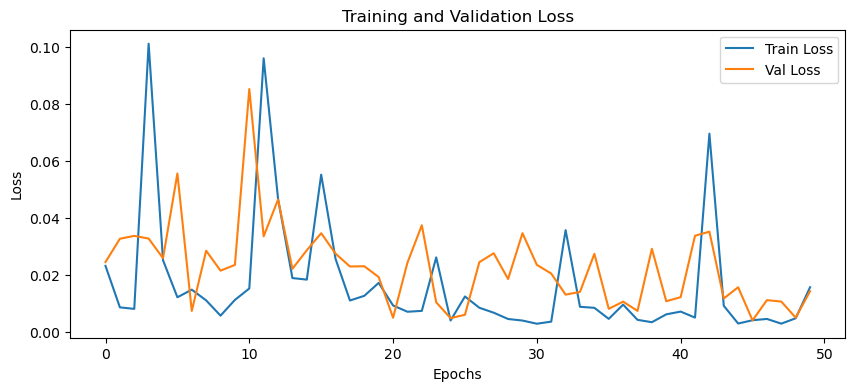

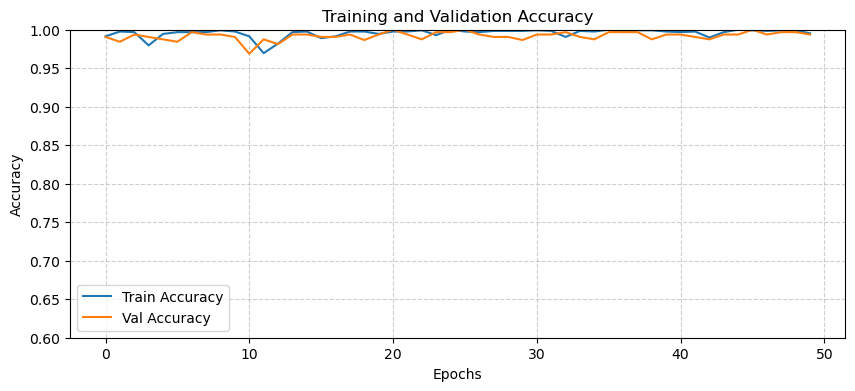

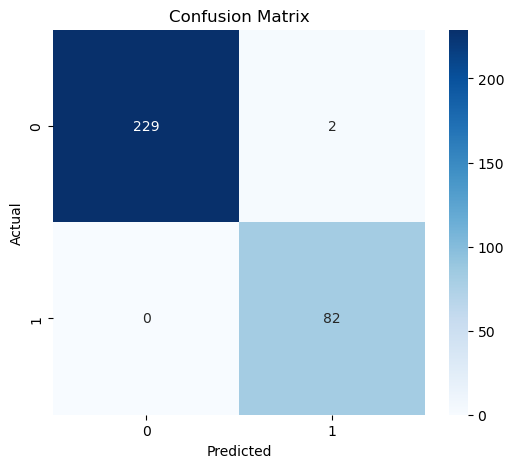

In [ ]:
num_epochs = 50
train_losses, train_accs = [], []
val_losses, val_accs = [], []

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

# -----------------------------
# 4. Training loop
# -----------------------------
for epoch in range(1, num_epochs + 1):
    model_2.train()
    train_loss, train_acc, num_batches = 0.0, 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, labels).item()
        num_batches += 1

    train_loss /= num_batches
    train_acc /= num_batches
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model_2.eval()
    val_loss, val_acc, val_batches = 0.0, 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_2(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels).item()
            val_batches += 1

            preds = torch.argmax(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    val_loss /= val_batches
    val_acc /= val_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# -----------------------------
# 5. Plot Loss & Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training and Validation Loss"); plt.legend(); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.ylim(0.6, 1.0)  # 🔹 Adjust this range to your liking (e.g., (0, 1) for full scale)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# -----------------------------
# 6. Confusion Matrix
# -----------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Convert to numpy
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Accuracy:  99.36%
Precision: 99.38%
Recall:    99.36%
F1 Score:  99.36%


Accuracy:   85.00%
Precision:  85.06%
Recall:     85.00%
F1 Score:   85.00%
Cohen Kappa: 0.7000
MCC:         0.7004

Average Inference Time per Image: 2.97 ms
Fastest Inference Time: 1.96 ms
Slowest Inference Time: 4.93 ms

Model Size: 2.32 MB


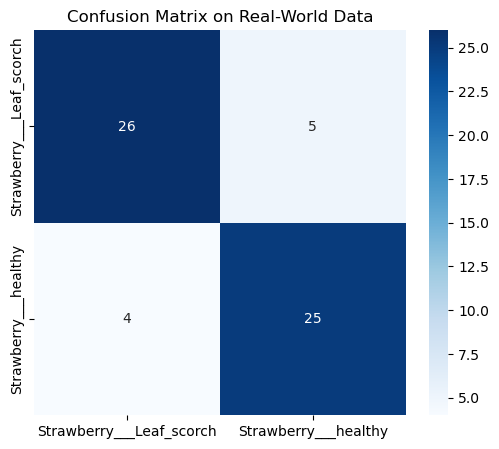

In [ ]:
import os
import time
from torchvision import transforms
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Path to real-world data
# -----------------------------
test_dir = r"C:\Users\iyera\Desktop\NEW_STRA\Real_Time_data_segmented_v2"

# Transformation
img_size = 64
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set model to eval
model_2.eval()
model_2.to(device)

# Map class indices to names
class_names = full_dataset.classes  # ['healthy', 'scrotch']

# -----------------------------
# Collect predictions and labels
# -----------------------------
y_true, y_pred = [], []
inference_times = []

for label_idx, class_folder in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Measure inference time
        start = time.time()
        with torch.no_grad():
            outputs = model_2(image)
        end = time.time()

        inference_times.append(end - start)

        pred_idx = torch.argmax(outputs, 1).item()

        y_true.append(label_idx)
        y_pred.append(pred_idx)

# -----------------------------
# Compute metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:   {accuracy*100:.2f}%")
print(f"Precision:  {precision*100:.2f}%")
print(f"Recall:     {recall*100:.2f}%")
print(f"F1 Score:   {f1*100:.2f}%")
print(f"Cohen Kappa: {kappa:.4f}")
print(f"MCC:         {mcc:.4f}")

# -----------------------------
# Inference time results
# -----------------------------
avg_inference = sum(inference_times) / len(inference_times)
print(f"\nAverage Inference Time per Image: {avg_inference*1000:.2f} ms")
print(f"Fastest Inference Time: {min(inference_times)*1000:.2f} ms")
print(f"Slowest Inference Time: {max(inference_times)*1000:.2f} ms")

# -----------------------------
# Model Size (temporary save)
# -----------------------------
model_path = "temp_model2.pth"
torch.save(model_2.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")
os.remove(model_path)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Real-World Data")
plt.show()


### Next-ViT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from einops import rearrange

# ----------------------------------------------------
# Basic Conv Block
# ----------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# ----------------------------------------------------
# Local Feature Aggregation (LFA) - simple conv-based
# ----------------------------------------------------
class LFA(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = ConvBlock(channels, channels)
    def forward(self, x):
        return self.conv(x)

# ----------------------------------------------------
# Nested Attention Block (NAB) - corrected for 3D tensors
# ----------------------------------------------------
class NestedAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.qkv = nn.Conv2d(channels, channels * 3, 1, 1, 0, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(x).view(B, 3, C, H * W)
        q, k, v = qkv[:,0], qkv[:,1], qkv[:,2]  # each: (B, C, N)

        # Corrected attention
        q = q.permute(0, 2, 1)  # (B, N, C)
        k = k.permute(0, 2, 1)  # (B, N, C)
        v = v.permute(0, 2, 1)  # (B, N, C)

        attn = torch.matmul(q, k.transpose(-2, -1)) / (C ** 0.5)  # (B, N, N)
        attn = self.softmax(attn)
        out = torch.matmul(attn, v)  # (B, N, C)
        out = out.permute(0, 2, 1).view(B, C, H, W)
        out = self.proj(out)
        return out

# ----------------------------------------------------
# Next-Transformer Block
# ----------------------------------------------------
class NextTransformerBlock(nn.Module):
    def __init__(self, channels, depth=2):
        super().__init__()
        self.lfa = LFA(channels)
        self.nab_blocks = nn.Sequential(*[NestedAttentionBlock(channels) for _ in range(depth)])
        self.conv1x1 = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        y = self.lfa(x)
        z = self.nab_blocks(y)
        z = self.conv1x1(z)
        return x + z  # residual

# ----------------------------------------------------
# Next-ViT Model
# ----------------------------------------------------
class NextViT(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stem = ConvBlock(3, 16, 3, 2, 1)    # 224 -> 112
        self.stage1 = ConvBlock(16, 32, 3, 2, 1) # 112 -> 56
        self.stage2 = ConvBlock(32, 64, 3, 2, 1) # 56 -> 28
        self.ntb1 = NextTransformerBlock(64, depth=2)
        self.stage3 = ConvBlock(64, 96, 3, 2, 1) # 28 -> 14
        self.ntb2 = NextTransformerBlock(96, depth=4)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.ntb1(x)
        x = self.stage3(x)
        x = self.ntb2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# ----------------------------------------------------
# Device, Model, Optimizer, Loss
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = NextViT(num_classes=2).to(device)

optimizer = AdamW(model_3.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

print("✅ Next-ViT ready with AdamW + L2 regularization")


✅ Next-ViT ready with AdamW + L2 regularization


Epoch [1/50] | Train Loss: 0.4542, Train Acc: 83.44% | Val Loss: 0.3476, Val Acc: 87.64%
Epoch [2/50] | Train Loss: 0.1719, Train Acc: 92.81% | Val Loss: 0.0934, Val Acc: 97.19%
Epoch [3/50] | Train Loss: 0.1278, Train Acc: 94.38% | Val Loss: 0.1449, Val Acc: 93.04%
Epoch [4/50] | Train Loss: 0.1432, Train Acc: 93.91% | Val Loss: 0.1407, Val Acc: 93.66%
Epoch [5/50] | Train Loss: 0.1624, Train Acc: 93.75% | Val Loss: 0.0767, Val Acc: 97.50%
Epoch [6/50] | Train Loss: 0.1204, Train Acc: 94.84% | Val Loss: 0.1147, Val Acc: 94.38%
Epoch [7/50] | Train Loss: 0.1044, Train Acc: 96.09% | Val Loss: 0.0816, Val Acc: 97.19%
Epoch [8/50] | Train Loss: 0.1075, Train Acc: 96.02% | Val Loss: 0.0868, Val Acc: 95.85%
Epoch [9/50] | Train Loss: 0.1866, Train Acc: 95.47% | Val Loss: 0.0798, Val Acc: 97.50%
Epoch [10/50] | Train Loss: 0.1466, Train Acc: 94.77% | Val Loss: 0.1069, Val Acc: 96.56%
Epoch [11/50] | Train Loss: 0.1088, Train Acc: 96.02% | Val Loss: 0.0731, Val Acc: 96.88%
Epoch [12/50] | Tra

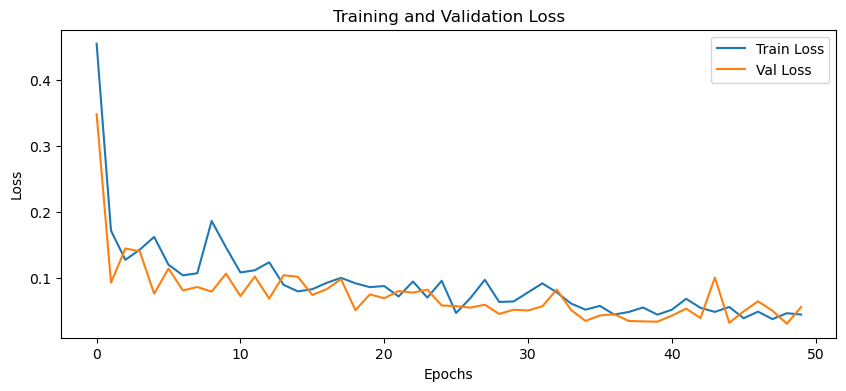

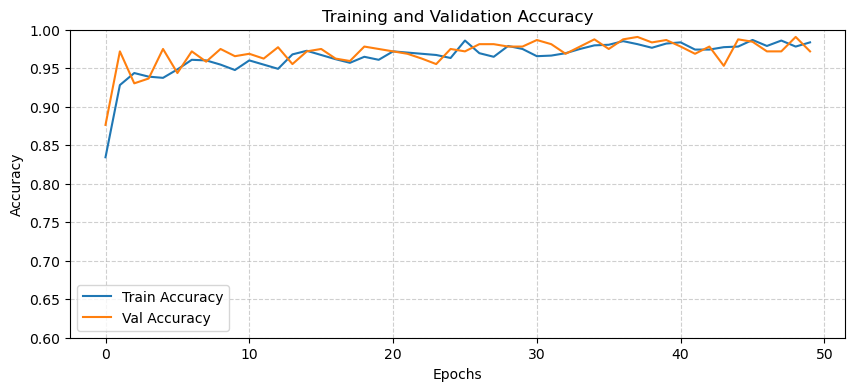

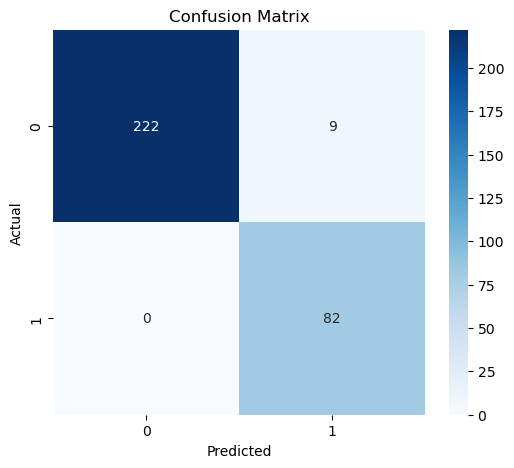

In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model_3.train()
    train_loss, train_acc, num_batches = 0.0, 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, labels).item()
        num_batches += 1
    train_loss /= num_batches
    train_acc /= num_batches
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model_3.eval()
    val_loss, val_acc, val_batches = 0.0, 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels).item()
            val_batches += 1
            preds = torch.argmax(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    val_loss /= val_batches
    val_acc /= val_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# -----------------------------
# 5. Plot Loss and Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend(); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.ylim(0.6, 1.0)  # 🔹 Adjust this range to your liking (e.g., (0, 1) for full scale)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# -----------------------------
# 6. Confusion Matrix
# -----------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Convert to numpy
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Accuracy:  97.12%
Precision: 97.41%
Recall:    97.12%
F1 Score:  97.17%


Accuracy:     86.67%
Precision:    87.38%
Recall:       86.67%
F1 Score:     86.64%
Cohen Kappa:  0.7342
MCC:          0.7408

Average Inference Time per Image: 2.29 ms
Fastest Inference Time: 1.39 ms
Slowest Inference Time: 4.00 ms

Model Size: 1.53 MB


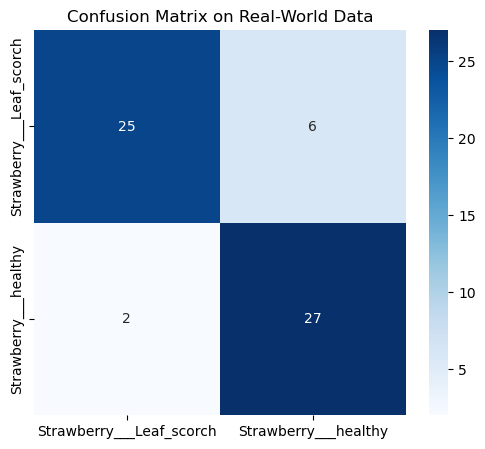

In [ ]:
import os
import time
from torchvision import transforms
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Path to real-world data
# -----------------------------
test_dir = r"C:\Users\iyera\Desktop\NEW_STRA\Real_Time_data_segmented_v2"

# Transformation
img_size = 64
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set model to eval
model_3.eval()
model_3.to(device)

# Map class indices to names
class_names = full_dataset.classes  # ['healthy', 'scrotch']

# -----------------------------
# Collect predictions and labels
# -----------------------------
y_true, y_pred = [], []
inference_times = []

for label_idx, class_folder in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Measure inference time
        start = time.time()
        with torch.no_grad():
            outputs = model_3(image)
        end = time.time()

        inference_times.append(end - start)

        pred_idx = torch.argmax(outputs, 1).item()

        y_true.append(label_idx)
        y_pred.append(pred_idx)

# -----------------------------
# Compute metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:     {accuracy*100:.2f}%")
print(f"Precision:    {precision*100:.2f}%")
print(f"Recall:       {recall*100:.2f}%")
print(f"F1 Score:     {f1*100:.2f}%")
print(f"Cohen Kappa:  {kappa:.4f}")
print(f"MCC:          {mcc:.4f}")

# -----------------------------
# Inference time results
# -----------------------------
avg_inference = sum(inference_times) / len(inference_times)
print(f"\nAverage Inference Time per Image: {avg_inference*1000:.2f} ms")
print(f"Fastest Inference Time: {min(inference_times)*1000:.2f} ms")
print(f"Slowest Inference Time: {max(inference_times)*1000:.2f} ms")

# -----------------------------
# Model Size (temporary save)
# -----------------------------
model_path = "temp_model3.pth"
torch.save(model_3.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")
os.remove(model_path)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Real-World Data")
plt.show()


### Efficient Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# -----------------------------
# 1. Linear Attention Block
# -----------------------------
class LinearAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        assert dim % num_heads == 0
        self.head_dim = dim // num_heads

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        q, k, v = qkv[:, :, 0], qkv[:, :, 1], qkv[:, :, 2]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Linear attention (softmax q/k separately)
        q = F.softmax(q, dim=-1)
        k = F.softmax(k, dim=-2)

        context = torch.matmul(k.transpose(-2, -1), v)
        out = torch.matmul(q, context)
        out = out.transpose(1, 2).reshape(B, N, C)
        return self.proj(out)

# -----------------------------
# 2. Feed Forward Block
# -----------------------------
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# 3. Efficient Transformer Block
# -----------------------------
class EfficientTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = LinearAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = FeedForward(dim, int(dim * mlp_ratio))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

# -----------------------------
# 4. Efficient Transformer Model
# -----------------------------
class EfficientTransformer(nn.Module):
    def __init__(self, in_channels=3, dim=128, depth=4, num_heads=8, mlp_ratio=4.0,
                 num_classes=2, img_size=64):
        super().__init__()
        self.dim = dim
        self.img_size = img_size
        self.seq_len = img_size * img_size

        self.input_proj = nn.Linear(in_channels, dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.seq_len, dim))
        self.layers = nn.ModuleList([
            EfficientTransformerBlock(dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)      # [B, seq_len, C]
        x = self.input_proj(x)                # [B, seq_len, dim]
        x = x + self.pos_embed

        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        x = x.mean(dim=1)                     # global average pooling
        return self.head(x)

# -----------------------------
# 5. Device, Model, Optimizer, Loss
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4 = EfficientTransformer(in_channels=3, dim=128, depth=4, num_heads=8,
                             num_classes=2, img_size=64).to(device)
optimizer = AdamW(model_4.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


Epoch [1/50] | Train Loss: 0.4930, Train Acc: 77.50% | Val Loss: 0.3087, Val Acc: 93.35%
Epoch [2/50] | Train Loss: 0.2326, Train Acc: 91.33% | Val Loss: 0.1582, Val Acc: 92.41%
Epoch [3/50] | Train Loss: 0.1677, Train Acc: 93.28% | Val Loss: 0.1803, Val Acc: 90.99%
Epoch [4/50] | Train Loss: 0.1523, Train Acc: 93.67% | Val Loss: 0.1597, Val Acc: 93.04%
Epoch [5/50] | Train Loss: 0.1386, Train Acc: 94.22% | Val Loss: 0.1422, Val Acc: 94.69%
Epoch [6/50] | Train Loss: 0.1533, Train Acc: 93.44% | Val Loss: 0.1033, Val Acc: 95.62%
Epoch [7/50] | Train Loss: 0.1247, Train Acc: 94.61% | Val Loss: 0.1200, Val Acc: 94.60%
Epoch [8/50] | Train Loss: 0.1069, Train Acc: 95.62% | Val Loss: 0.1304, Val Acc: 94.51%
Epoch [9/50] | Train Loss: 0.1192, Train Acc: 94.92% | Val Loss: 0.1132, Val Acc: 93.66%
Epoch [10/50] | Train Loss: 0.1243, Train Acc: 94.92% | Val Loss: 0.1235, Val Acc: 93.04%
Epoch [11/50] | Train Loss: 0.1074, Train Acc: 96.17% | Val Loss: 0.0996, Val Acc: 96.56%
Epoch [12/50] | Tra

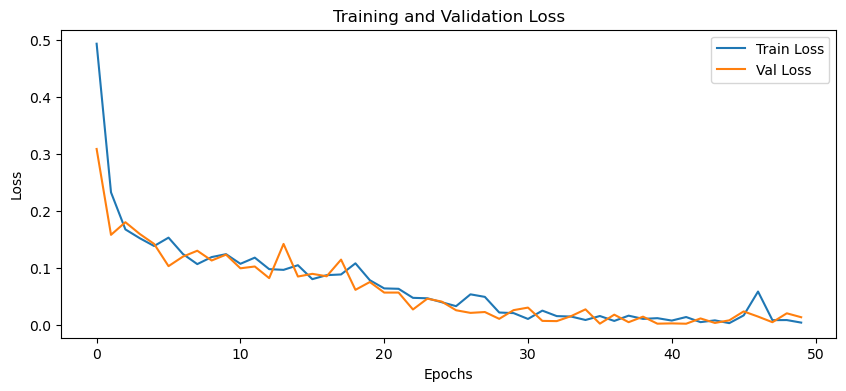

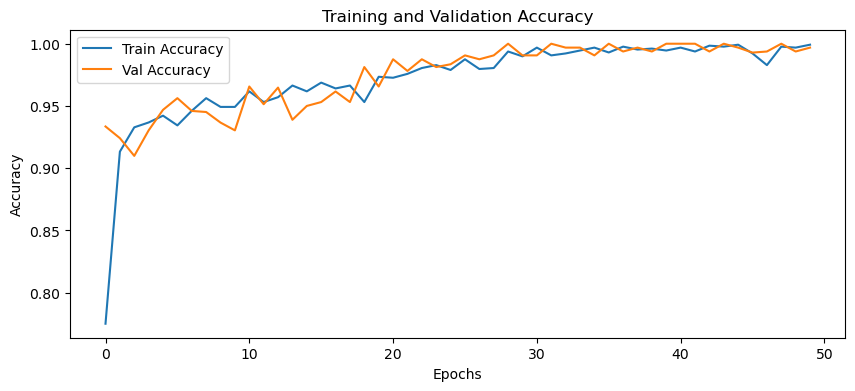

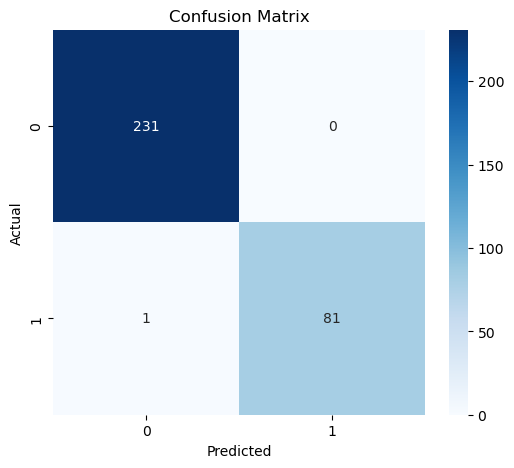

In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model_4.train()
    train_loss, train_acc, num_batches = 0.0, 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_4(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, labels).item()
        num_batches += 1
    train_loss /= num_batches
    train_acc /= num_batches
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model_4.eval()
    val_loss, val_acc, val_batches = 0.0, 0.0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_4(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels).item()
            val_batches += 1
            preds = torch.argmax(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    val_loss /= val_batches
    val_acc /= val_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# -----------------------------
# 5. Plot Loss and Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend(); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(); plt.show()

# -----------------------------
# 6. Confusion Matrix
# -----------------------------
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Convert to numpy
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1 Score:  {f1*100:.2f}%")


Accuracy:  99.68%
Precision: 99.68%
Recall:    99.68%
F1 Score:  99.68%


Accuracy:     76.67%
Precision:    81.54%
Recall:       76.67%
F1 Score:     75.52%
Cohen Kappa:  0.5265
MCC:          0.5761

Average Inference Time per Image: 2.12 ms
Fastest Inference Time: 1.00 ms
Slowest Inference Time: 4.00 ms

Model Size: 5.04 MB


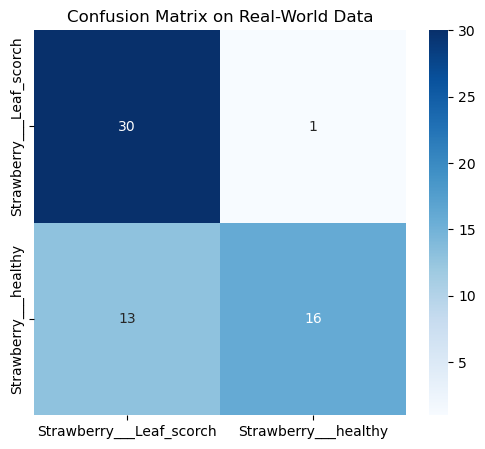

In [ ]:
import os
import time
from torchvision import transforms
from PIL import Image
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# Path to real-world data
# -----------------------------
test_dir = r"C:\Users\iyera\Desktop\NEW_STRA\Real_Time_data_segmented_v2"

# Transformation
img_size = 64
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set model to eval
model_4.eval()
model_4.to(device)

# Map class indices to names
class_names = full_dataset.classes  # ['healthy', 'scrotch']

# -----------------------------
# Collect predictions and labels
# -----------------------------
y_true, y_pred = [], []
inference_times = []

for label_idx, class_folder in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Measure inference time
        start = time.time()
        with torch.no_grad():
            outputs = model_4(image)
        end = time.time()

        inference_times.append(end - start)

        pred_idx = torch.argmax(outputs, 1).item()

        y_true.append(label_idx)
        y_pred.append(pred_idx)

# -----------------------------
# Compute metrics
# -----------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:     {accuracy*100:.2f}%")
print(f"Precision:    {precision*100:.2f}%")
print(f"Recall:       {recall*100:.2f}%")
print(f"F1 Score:     {f1*100:.2f}%")
print(f"Cohen Kappa:  {kappa:.4f}")
print(f"MCC:          {mcc:.4f}")

# -----------------------------
# Inference time results
# -----------------------------
avg_inference = sum(inference_times) / len(inference_times)
print(f"\nAverage Inference Time per Image: {avg_inference*1000:.2f} ms")
print(f"Fastest Inference Time: {min(inference_times)*1000:.2f} ms")
print(f"Slowest Inference Time: {max(inference_times)*1000:.2f} ms")

# -----------------------------
# Model Size (temporary save)
# -----------------------------
model_path = "temp_model4.pth"
torch.save(model_4.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel Size: {model_size_mb:.2f} MB")
os.remove(model_path)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Real-World Data")
plt.show()


### Ensembling Method

### Hybrid Model

In [ ]:
# -----------------------------
# Feature Extractor Wrapper
# -----------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        # Remove last layer / classifier
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

# Wrap your trained ViTs
feat_model_1 = FeatureExtractor(model_1).to(device).eval()
feat_model_2 = FeatureExtractor(model_2).to(device).eval()
feat_model_3 = FeatureExtractor(model_3).to(device).eval()

In [ ]:
# -----------------------------
# Hybrid FC Classifier
# -----------------------------
# First, determine feature dims
with torch.no_grad():
    dummy = torch.randn(1, 3, img_size, img_size).to(device)
    dim1 = feat_model_1(dummy).shape[1]
    dim2 = feat_model_2(dummy).shape[1]
    dim3 = feat_model_3(dummy).shape[1]

print(f"Feature dims: {dim1}, {dim2}, {dim3}")

Feature dims: 96, 96, 96


In [ ]:
hybrid_fc = nn.Sequential(
    nn.Linear(dim1 + dim2 + dim3, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(class_names))
).to(device)

# -----------------------------
# Freeze base models
# -----------------------------
for param in feat_model_1.parameters():
    param.requires_grad = False
for param in feat_model_2.parameters():
    param.requires_grad = False
for param in feat_model_3.parameters():
    param.requires_grad = False

# -----------------------------
# Optimizer and loss
# -----------------------------
optimizer = torch.optim.Adam(hybrid_fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50

for epoch in range(num_epochs):
    hybrid_fc.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Feature extraction
        f1 = feat_model_1(images)
        f2 = feat_model_2(images)
        f3 = feat_model_3(images)
        hybrid_features = torch.cat([f1, f2, f3], dim=1)

        # Forward pass
        outputs = hybrid_fc(hybrid_features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Save training stats
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # -----------------------------
    # VALIDATION LOOP
    # -----------------------------
    hybrid_fc.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            f1 = feat_model_1(images)
            f2 = feat_model_2(images)
            f3 = feat_model_3(images)
            hybrid_features = torch.cat([f1, f2, f3], dim=1)

            outputs = hybrid_fc(hybrid_features)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_running_loss += loss.item() * labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")



Epoch 1/50: Train Loss=0.0285, Train Acc=0.9904, Val Loss=0.0165, Val Acc=0.9968
Epoch 2/50: Train Loss=0.0023, Train Acc=0.9992, Val Loss=0.0169, Val Acc=0.9936
Epoch 3/50: Train Loss=0.0007, Train Acc=1.0000, Val Loss=0.0202, Val Acc=0.9936
Epoch 4/50: Train Loss=0.0003, Train Acc=1.0000, Val Loss=0.0136, Val Acc=0.9936
Epoch 5/50: Train Loss=0.0002, Train Acc=1.0000, Val Loss=0.0196, Val Acc=0.9904
Epoch 6/50: Train Loss=0.0008, Train Acc=1.0000, Val Loss=0.0089, Val Acc=0.9968
Epoch 7/50: Train Loss=0.0022, Train Acc=0.9992, Val Loss=0.0246, Val Acc=0.9936
Epoch 8/50: Train Loss=0.0003, Train Acc=1.0000, Val Loss=0.0286, Val Acc=0.9936
Epoch 9/50: Train Loss=0.0011, Train Acc=0.9992, Val Loss=0.0348, Val Acc=0.9936
Epoch 10/50: Train Loss=0.0007, Train Acc=0.9992, Val Loss=0.0091, Val Acc=0.9968
Epoch 11/50: Train Loss=0.0000, Train Acc=1.0000, Val Loss=0.0561, Val Acc=0.9872
Epoch 12/50: Train Loss=0.0003, Train Acc=1.0000, Val Loss=0.0007, Val Acc=1.0000
Epoch 13/50: Train Loss=0

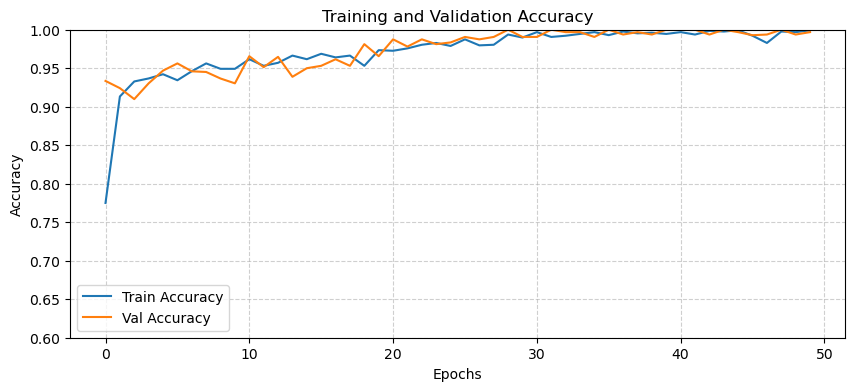

In [ ]:

# Plot Accuracy
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.ylim(0.6, 1.0)  # 🔹 Adjust this range to your liking (e.g., (0, 1) for full scale)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

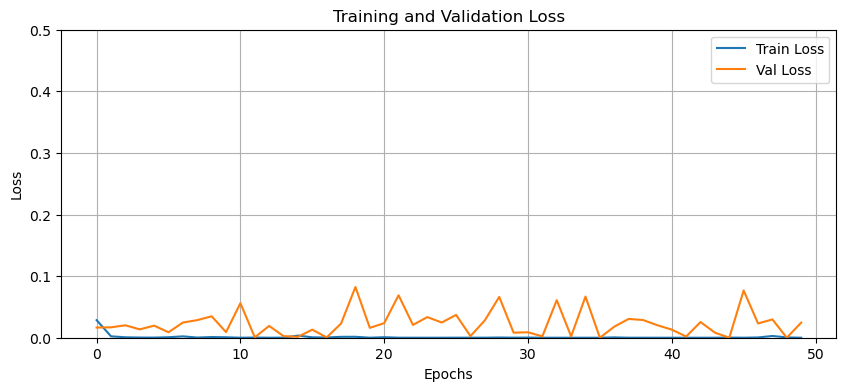

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Best range for your loss scale (clean + professional)
plt.ylim(0, 0.5)

plt.grid(True)
plt.show()


Validation Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


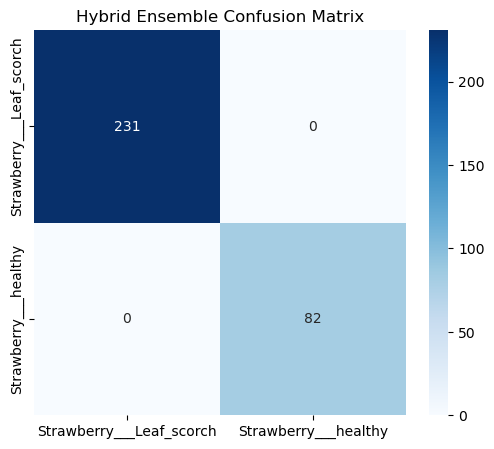

In [ ]:
hybrid_fc.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        f1 = feat_model_1(images)
        f2 = feat_model_2(images)
        f3 = feat_model_3(images)
        hybrid_features = torch.cat([f1, f2, f3], dim=1)
        outputs = hybrid_fc(hybrid_features)
        preds = torch.argmax(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Validation Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Hybrid Ensemble Confusion Matrix")
plt.show()


In [ ]:
############# TEST ###############

In [ ]:
def hybrid_predict(image_tensor):
    """
    Predicts class index for a single image using the hybrid feature-level ensemble.
    """
    image_tensor = image_tensor.to(device).unsqueeze(0)  # add batch dim
    with torch.no_grad():
        # Extract features from all 3 ViTs
        f1 = feat_model_1(image_tensor)
        f2 = feat_model_2(image_tensor)
        f3 = feat_model_3(image_tensor)

        # Concatenate features
        hybrid_features = torch.cat([f1, f2, f3], dim=1)

        # Pass through trained hybrid_fc classifier
        outputs = hybrid_fc(hybrid_features)
        pred_idx = torch.argmax(outputs, 1).item()

    return pred_idx


Accuracy:       91.67%
Precision:      91.72%
Recall:         91.67%
F1 Score:       91.67%
Cohen Kappa:    0.8333
MCC:            0.8338

Avg Inference Time:  38.16 ms
Fastest Inference:   12.00 ms
Slowest Inference:   113.10 ms

Hybrid Model Total Size: 7.62 MB
  - Feature Model 1:      3.46 MB
  - Feature Model 2:      2.34 MB
  - Feature Model 3:      1.53 MB
  - Hybrid FC Head:       0.29 MB


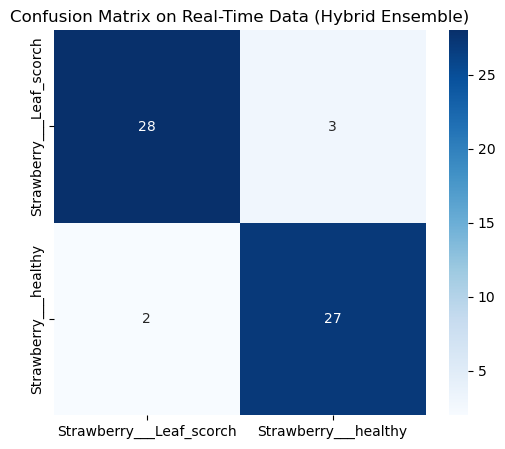

In [ ]:
import time
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# --------------------------------------
# Prediction loop with timing
# --------------------------------------
y_true, y_pred = [], []
inference_times = []

for label_idx, class_folder in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(folder_path):
        continue

    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        image = transform(image)

        # Measure inference time
        start = time.time()
        pred_idx = hybrid_predict(image)
        end = time.time()

        inference_times.append(end - start)

        y_true.append(label_idx)
        y_pred.append(pred_idx)

# --------------------------------------
# Classification metrics
# --------------------------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy:       {accuracy*100:.2f}%")
print(f"Precision:      {precision*100:.2f}%")
print(f"Recall:         {recall*100:.2f}%")
print(f"F1 Score:       {f1*100:.2f}%")
print(f"Cohen Kappa:    {kappa:.4f}")
print(f"MCC:            {mcc:.4f}")

# --------------------------------------
# Inference time stats
# --------------------------------------
avg_inf = sum(inference_times) / len(inference_times)
print(f"\nAvg Inference Time:  {avg_inf*1000:.2f} ms")
print(f"Fastest Inference:   {min(inference_times)*1000:.2f} ms")
print(f"Slowest Inference:   {max(inference_times)*1000:.2f} ms")

# --------------------------------------
# Model Size (sum of 3 feature extractors + hybrid_fc)
# --------------------------------------
def get_model_size(model, filename):
    torch.save(model.state_dict(), filename)
    size = os.path.getsize(filename) / (1024 * 1024)
    os.remove(filename)
    return size

size_f1 = get_model_size(feat_model_1, "temp_f1.pth")
size_f2 = get_model_size(feat_model_2, "temp_f2.pth")
size_f3 = get_model_size(feat_model_3, "temp_f3.pth")
size_fc = get_model_size(hybrid_fc, "temp_fc.pth")

total_size = size_f1 + size_f2 + size_f3 + size_fc
print(f"\nHybrid Model Total Size: {total_size:.2f} MB")
print(f"  - Feature Model 1:      {size_f1:.2f} MB")
print(f"  - Feature Model 2:      {size_f2:.2f} MB")
print(f"  - Feature Model 3:      {size_f3:.2f} MB")
print(f"  - Hybrid FC Head:       {size_fc:.2f} MB")

# --------------------------------------
# Confusion Matrix
# --------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix on Real-Time Data (Hybrid Ensemble)")
plt.show()
